In [1]:
import vaex
import vaex.jupyter.model as vjm

import numpy as np
import matplotlib.pyplot as plt

import mhealpy as mh

In [36]:
from numba import jit, int64, vectorize

In [2]:
df = vaex.open('./atl06_03_11.arrow')

In [3]:
df

#,id,lat,lon,slope_y,slope_x,slope_x_sigma,h_li,s_li,q_flag,s_fg,snr,h_rb,bsnow_conf,cloud_flg_asr,cloud_flg_atm,msw_flag,fbsnow_h,bsnow_od,layer_flag,bckgrd,e_bckgrd,n_fit_photons,w_surface_window_final,t_year,cycle,track,x,y
0,1443587,-79.00604150693235,176.34489505559952,0.0034970236010849476,0.045052722096443176,0.0008298112079501152,-19.586994171142578,0.012193245813250542,0,0,0.0,0.1700313538312912,-1,2,1,3,29.979246139526367,0.26861944794654846,1,28285.419921875,0.0,522,3.0,2019-03-29 07:13:52.971019,3,gt1l,76147.62450344954,-1192036.1950727522
1,1443588,-79.00621643747844,176.34471657932238,0.004264393355697393,0.05056241527199745,0.0008830373408272862,-18.607820510864258,0.012879230082035065,0,0,0.0,0.18802492320537567,-1,2,1,3,29.979246139526367,0.2682749032974243,1,25933.798828125,0.0,541,3.0,2019-03-29 07:13:52.973831,3,gt1l,76150.11884253839,-1192016.878556122
2,1443604,-79.00598340764218,-128.34968452426844,0.0011884707491844893,-0.008782525546848774,0.0012873366940766573,1393.30810546875,0.022358529269695282,0,0,0.0,0.16403409838676453,-1,4,1,2,-15.545355796813965,0.025605319067835808,1,29848.724609375,0.0,134,3.0,2019-06-16 23:44:16.580875,3,gt1l,-936751.2677578111,-741121.435694096
3,1443605,-79.0061584310981,-128.34986074738637,0.0014111476484686136,-0.0077179535292088985,0.0013354523107409477,1393.1937255859375,0.02100951410830021,0,0,0.0,0.17921173572540283,-1,4,1,2,-13.435805320739746,0.025563444942235947,1,32934.61328125,0.0,141,3.0,2019-06-16 23:44:16.583689,3,gt1l,-936733.9871437278,-741112.4484165515
4,1443606,-79.00633341593905,-128.35003802228633,0.0012659610947594047,-0.0070463260635733604,0.0011699371971189976,1393.045166015625,0.027471376582980156,0,0,0.0,0.17215631902217865,-1,4,1,2,-11.32924747467041,0.02552163042128086,1,35919.10546875,0.0,148,3.0,2019-06-16 23:44:16.586500,3,gt1l,-936716.6963032028,-741103.4808569406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"865,273,099",1565333,-78.99504226798936,158.03591094289823,0.007495594210922718,0.0078804399818182,0.002683431375771761,1279.90234375,0.05482017993927002,0,0,0.0,0.15907801687717438,-1,5,1,1,29.979246139526367,0.02713683247566223,1,2268.45654296875,0.0,21,3.0,2019-06-23 17:41:49.183559,3,gt3r,447210.19721519714,-1108884.5834480259
"865,273,100",1565334,-78.99486756514892,158.03572581694618,0.006783090066164732,0.012846322730183601,0.0031797189731150866,1280.02392578125,0.05916494503617287,0,0,0.0,0.13116207718849182,-1,5,1,1,29.979246139526367,0.02713673934340477,1,1946.7774658203125,0.0,21,3.0,2019-06-23 17:41:49.186370,3,gt3r,447220.92165426933,-1108900.846272008
"865,273,101",1565335,-78.99469283993268,158.03554127839766,0.007498532999306917,-0.0022711576893925667,0.0016771184746176004,1279.994873046875,0.026095101609826088,0,0,0.0,0.0632103830575943,-1,5,1,1,29.979246139526367,0.02713664434850216,1,1209.9652099609375,0.0,24,3.0,2019-06-23 17:41:49.189189,3,gt3r,447231.6357510542,-1108917.115896332
"865,273,102",1565336,-78.99451809314117,158.03535733441748,0.008078711107373238,9.721379319671541e-05,0.0028819788713008165,1279.9814453125,0.05285322666168213,0,0,0.0,0.14162179827690125,-1,5,1,1,29.979246139526367,0.02713654935359955,1,177.30709838867188,0.0,21,3.0,2019-06-23 17:41:49.192016,3,gt3r,447242.3393336775,-1108933.3922961077


In [4]:
!du -csh ./atl06_03_11.arrow

91G	./atl06_03_11.arrow
91G	total


As we can see, this 91-day orbit includes 865,273,103 observations, packed in a file that is 91 gigabytes large. We can plot data with some simple resampling to polar sterographic south bins, which are already encoded as the x and y columns in the vaex array

In [5]:
x_axis = vjm.Axis(df=df, expression=df.x, shape=1000)
y_axis = vjm.Axis(df=df, expression=df.y, shape=1000)
y_axis

Axis(bin_centers=None, exception=None, expression=y, max=None, min=None, shape=1000, shape_default=64, slice=None, status=Status.NO_LIMITS)

In [6]:
await vaex.jupyter.gather()  # wait until Vaex is done with all background computation

In [7]:
data_array_widget = df.widget.data_array(axes=[y_axis, x_axis], selection=[None, 'default'])
data_array_widget  # being the last expression in the cell, Jupyter  will 'display' the widget

DataArray(children=[Container(children=[ProgressCircularNoAnimation(color='#9ECBF5', size=30, text='', value=1…

In [8]:
await vaex.jupyter.gather()
# get a reference to the xarray DataArray object
data_array = data_array_widget.model.grid

In [9]:
data_array

<xarray.DataArray (selection: 1, y: 1000, x: 1000)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])
Coordinates:
  * selection  (selection) object None
  * y          (y) float64 -1.195e+06 -1.192e+06 -1.19e+06 ... 1.2e+06 1.203e+06
  * x          (x) float64 -1.195e+06 -1.192e+06 ... 1.192e+06 1.195e+06

In [10]:
data_array.dims

('selection', 'y', 'x')

In [11]:
data_array.coords

Coordinates:
  * selection  (selection) object None
  * y          (y) float64 -1.195e+06 -1.192e+06 -1.19e+06 ... 1.2e+06 1.203e+06
  * x          (x) float64 -1.195e+06 -1.192e+06 ... 1.192e+06 1.195e+06

To be perfectly explicit about what is happening and what is about to happen-- we've initiated a template xarray grid, that we'll fill and plot with data that we calculate from the vaex array.

In [12]:
df.select(df.q_flag == 1)

In [13]:
# NOTE: da is short for 'data array'
def plot2d(da):
    plt.figure(figsize=(8, 8))
    ar = da.data[0]  # take the numpy data, and select take the selection
    print(f'imshow of a numpy array of shape: {ar.shape}')
    plt.imshow(np.log1p(ar.T), origin='lower')

df.widget.data_array(axes=[x_axis, y_axis], display_function=plot2d, selection=['default'])

DataArray(children=[Container(children=[ProgressCircularNoAnimation(color='#9ECBF5', size=30, text='', value=1…

In [14]:
selection_widget = df.widget.selection_expression()
selection_widget

ExpressionSelectionTextArea(label='Filter by custom expression', placeholder='Enter a custom (boolean) express…

In [16]:
await vaex.jupyter.gather()
w = df.widget.counter_selection('default', lazy=True)
w

Counter(characters=['&nbsp;', '&nbsp;', '&nbsp;', '&nbsp;', '3', '5', ',', '9', '7', '5', ',', '3', '0', '3'],…

Tiling
--------

The `mhealpy` library is an superset of the `healpy` library that adds support for multiresolution healpix maps:

![fig2](fig4.png "Title")

The astronomy community uses a different indexing scheme then the 'morton' ordering discribed in the previous section. There's actually three different schemes that are provided for: `ring`, `nested` and `uniq`, with the first two being fixed resolution, and the last being multiresolution.

The multiresolution scheme has interesting implications for satellite data; for one thing, orbital convergence means that the sample resolution increases towards the poles, and decreases towards the equator. With the multiresolution naming scheme, it's perfectly reasonable to change the tesselation order to balance roughly equivelent numbers of observations per shard. For now we'll keep to a fixed layout, mainly so that query operations are still straightforward to formulate and execute, but it's worth keeping the application in mind.

There are facilities for converting between to representations, and certain index methods are optimized for different types of plotting methods. We can visulize our data location and extent using the built in methods.

In [18]:
# How to access raw data values to pass to functions
df.lat.as_numpy().values

array([-79.00604151, -79.00621644, -79.00598341, ..., -78.99469284,
       -78.99451809, -78.99434333])

We have to decide on a chunk size. It's not totally obvious how to do this, but we can guess based on the mean cell center spacing, which is simple to calculate:

In [19]:
def order2res(order):
    res = 111* 58.6323*.5**order
    return res

for res in range(20):
    print(str(order2res(res))+ ' km at tesselation order ' + str(res))

6508.1853 km at tesselation order 0
3254.09265 km at tesselation order 1
1627.046325 km at tesselation order 2
813.5231625 km at tesselation order 3
406.76158125 km at tesselation order 4
203.380790625 km at tesselation order 5
101.6903953125 km at tesselation order 6
50.84519765625 km at tesselation order 7
25.422598828125 km at tesselation order 8
12.7112994140625 km at tesselation order 9
6.35564970703125 km at tesselation order 10
3.177824853515625 km at tesselation order 11
1.5889124267578125 km at tesselation order 12
0.7944562133789063 km at tesselation order 13
0.39722810668945313 km at tesselation order 14
0.19861405334472657 km at tesselation order 15
0.09930702667236328 km at tesselation order 16
0.04965351333618164 km at tesselation order 17
0.02482675666809082 km at tesselation order 18
0.01241337833404541 km at tesselation order 19


In [20]:
# Set static resolution... order 10?
nside = 2**10

# Convert locations to healpix
#healidx = df.apply(mh.hp.ang2pix, arguments=[df.lon, df.lat, lonlat=True])
healidx = mh.hp.ang2pix(nside,df.lon.as_numpy().values, df.lat.as_numpy().values, lonlat=True) #, nest=True)
#test = mh.containers.HealpixMap(uniq=mh.nest2uniq(nside=2**13, ipix=healidx.ravel()))
# Static map
test = mh.containers.HealpixMap(nside=nside)

In [21]:
len(healidx)

865273104

In [22]:
# Multilevel map, from static map
#mtest = test.moc_from_pixels(nside=nside, pixels=healidx.ravel() )

In [23]:
# just a plain numpy array
m = np.zeros(mh.hp.nside2npix(nside))
m[healidx.ravel()] += 1

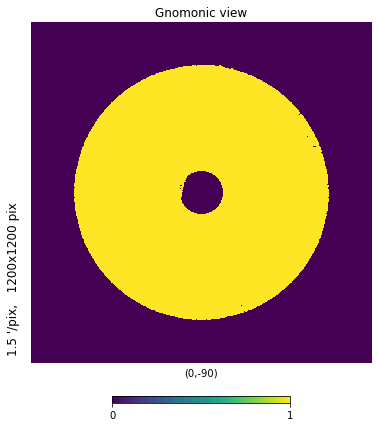

In [24]:
# Centered on the south pole
mh.hp.gnomview(m, rot=[0,-90], xsize=1200, ysize=1200)# , nest=True)

In [25]:
len(np.unique(healidx))

113307

In [26]:
91000/113307

0.8031277855737068

...probably too small. Chunks are under a meg. Let's bump up by three orders:

In [27]:
# Set static resolution... order 7
nside = 2**7

# Convert locations to healpix
#healidx = df.apply(mh.hp.ang2pix, arguments=[str(nside), df.lon, df.lat, 'False', 'True'])
healidx_7 = mh.hp.ang2pix(nside,df.lon.as_numpy().values, df.lat.as_numpy().values, lonlat=True) #, nest=True)
#test = mh.containers.HealpixMap(uniq=mh.nest2uniq(nside=2**13, ipix=healidx.ravel()))
# Static map
#test = mh.containers.HealpixMap(nside=nside)

In [28]:
len(np.unique(healidx_7))

1946

In [29]:
91000/1946

46.76258992805755

46 megs... seems better, lets do a few plots:

In [30]:
uhealpix7 = np.unique(healidx_7)

/nix/store/5kld536dkk8cmfy3wk8xkrdg1yzmh7h5-python3-3.8.9-env/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/nix/store/5kld536dkk8cmfy3wk8xkrdg1yzmh7h5-python3-3.8.9-env/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/nix/store/5kld536dkk8cmfy3wk8xkrdg1yzmh7h5-python3-3.8.9-env/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/nix/store/5kld536dkk8cmfy3wk8xkrdg1yzmh7h5-python3-3.8.9-env/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


([<matplotlib.lines.Line2D at 0x7f189ab45c40>],
 <healpy.projector.GnomonicProj at 0x7f1914c86a60>)

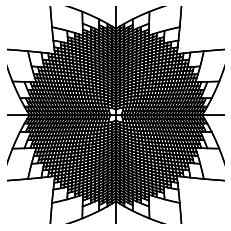

In [31]:
test = mh.containers.HealpixMap(nside=nside)
# Multilevel map, from static map
mtest = test.moc_from_pixels(nside=nside, pixels=uhealpix7.ravel() )
mtest.plot_grid(proj='gnom',rot=[0,-90],ysize=1200, xsize=1200)

...hard to tell. This level could work, but so could another order up. We'll try one more level:

In [34]:
nestcoords = np.load('./nest.npy')
parents = np.load('./parents.npy')
uniq = np.load('./uniq.npy')
normed= np.load('./normed.npy')

In [35]:
df['normed'] = normed
df['parents'] = parents
df['nest'] = nest

NameError: name 'nest' is not defined

In [26]:
@vectorize([int64(int64, int64)])#, target='cuda')
def VaexNorm2Mort(normed, parents):
    order = 18
    mask = np.int64(3*4**(order-1))
    res = np.zeros(order,dtype=np.int64)
    num = 0
    for j, i in enumerate(range(order, 0, -1)):
        nextBit = (normed & mask) >> ((2*i) - 2)
        num += (nextBit+1) * 10**(i-1)
        mask = mask >> 2
    parents = parents- 6
    parents = parents * 10**(order)
    num = num + parents
    return num

In [32]:
'''
nside = 2**18

def convertcoords(lon, lat):
    healp = mh.hp.ang2pix(nside, lon, lat, nest=True, lonlat=True)
    return healp

# Convert locations to healpix
df['nest'] = df.apply(convertcoords, arguments=[df.lon, df.lat])
'''

"\nnside = 2**18\n\ndef convertcoords(lon, lat):\n    healp = mh.hp.ang2pix(nside, lon, lat, nest=True, lonlat=True)\n    return healp\n\n# Convert locations to healpix\ndf['nest'] = df.apply(convertcoords, arguments=[df.lon, df.lat])\n"

In [ ]:
df

In [32]:
#nestcoords = df.nest.as_numpy().values

In [75]:
nestcoords

array([619894464536, 619894464525, 688946510872, ..., 619810773774,
       619810773775, 619810773786])

In [80]:
df['nest'] = nestcoords

In [81]:
df

#,id,lat,lon,slope_y,slope_x,slope_x_sigma,h_li,s_li,q_flag,s_fg,snr,h_rb,bsnow_conf,cloud_flg_asr,cloud_flg_atm,msw_flag,fbsnow_h,bsnow_od,layer_flag,bckgrd,e_bckgrd,n_fit_photons,w_surface_window_final,t_year,cycle,track,x,y,nest
0,1443587,-79.00604150693235,176.34489505559952,0.0034970236010849476,0.045052722096443176,0.0008298112079501152,-19.586994171142578,0.012193245813250542,0,0,0.0,0.1700313538312912,-1,2,1,3,29.979246139526367,0.26861944794654846,1,28285.419921875,0.0,522,3.0,2019-03-29 07:13:52.971019,3,gt1l,76147.62450344954,-1192036.1950727522,619894464536
1,1443588,-79.00621643747844,176.34471657932238,0.004264393355697393,0.05056241527199745,0.0008830373408272862,-18.607820510864258,0.012879230082035065,0,0,0.0,0.18802492320537567,-1,2,1,3,29.979246139526367,0.2682749032974243,1,25933.798828125,0.0,541,3.0,2019-03-29 07:13:52.973831,3,gt1l,76150.11884253839,-1192016.878556122,619894464525
2,1443604,-79.00598340764218,-128.34968452426844,0.0011884707491844893,-0.008782525546848774,0.0012873366940766573,1393.30810546875,0.022358529269695282,0,0,0.0,0.16403409838676453,-1,4,1,2,-15.545355796813965,0.025605319067835808,1,29848.724609375,0.0,134,3.0,2019-06-16 23:44:16.580875,3,gt1l,-936751.2677578111,-741121.435694096,688946510872
3,1443605,-79.0061584310981,-128.34986074738637,0.0014111476484686136,-0.0077179535292088985,0.0013354523107409477,1393.1937255859375,0.02100951410830021,0,0,0.0,0.17921173572540283,-1,4,1,2,-13.435805320739746,0.025563444942235947,1,32934.61328125,0.0,141,3.0,2019-06-16 23:44:16.583689,3,gt1l,-936733.9871437278,-741112.4484165515,688946510872
4,1443606,-79.00633341593905,-128.35003802228633,0.0012659610947594047,-0.0070463260635733604,0.0011699371971189976,1393.045166015625,0.027471376582980156,0,0,0.0,0.17215631902217865,-1,4,1,2,-11.32924747467041,0.02552163042128086,1,35919.10546875,0.0,148,3.0,2019-06-16 23:44:16.586500,3,gt1l,-936716.6963032028,-741103.4808569406,688946510855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"865,273,099",1565333,-78.99504226798936,158.03591094289823,0.007495594210922718,0.0078804399818182,0.002683431375771761,1279.90234375,0.05482017993927002,0,0,0.0,0.15907801687717438,-1,5,1,1,29.979246139526367,0.02713683247566223,1,2268.45654296875,0.0,21,3.0,2019-06-23 17:41:49.183559,3,gt3r,447210.19721519714,-1108884.5834480259,619810773769
"865,273,100",1565334,-78.99486756514892,158.03572581694618,0.006783090066164732,0.012846322730183601,0.0031797189731150866,1280.02392578125,0.05916494503617287,0,0,0.0,0.13116207718849182,-1,5,1,1,29.979246139526367,0.02713673934340477,1,1946.7774658203125,0.0,21,3.0,2019-06-23 17:41:49.186370,3,gt3r,447220.92165426933,-1108900.846272008,619810773772
"865,273,101",1565335,-78.99469283993268,158.03554127839766,0.007498532999306917,-0.0022711576893925667,0.0016771184746176004,1279.994873046875,0.026095101609826088,0,0,0.0,0.0632103830575943,-1,5,1,1,29.979246139526367,0.02713664434850216,1,1209.9652099609375,0.0,24,3.0,2019-06-23 17:41:49.189189,3,gt3r,447231.6357510542,-1108917.115896332,619810773774
"865,273,102",1565336,-78.99451809314117,158.03535733441748,0.008078711107373238,9.721379319671541e-05,0.0028819788713008165,1279.9814453125,0.05285322666168213,0,0,0.0,0.14162179827690125,-1,5,1,1,29.979246139526367,0.02713654935359955,1,177.30709838867188,0.0,21,3.0,2019-06-23 17:41:49.192016,3,gt3r,447242.3393336775,-1108933.3922961077,619810773775


In [86]:
uniq = mh.nest2uniq(2**18, nestcoords)

In [87]:
parents = unique2parent(uniq)

In [88]:
normed = heal_norm(parents, order, uniq)

In [99]:
#order = 18

#def convertNest2Mort(nest):
#    uniq = mh.nest2uniq(2**order, nest)
#    parents = unique2parent(uniq)
#    normed = heal_norm(parents,order, uniq)

#def normWrap(norms, parents):
#    mortons = norm2morton(order,norms, parents)
#    return mortons

# df['midx'] = df.apply(normWrap, arguments=[df.normed, df.parents], vectorize=True)

In [57]:
df

#,id,lat,lon,slope_y,slope_x,slope_x_sigma,h_li,s_li,q_flag,s_fg,snr,h_rb,bsnow_conf,cloud_flg_asr,cloud_flg_atm,msw_flag,fbsnow_h,bsnow_od,layer_flag,bckgrd,e_bckgrd,n_fit_photons,w_surface_window_final,t_year,cycle,track,x,y,normed,parents,midx,midx7,basin2,midx11,basin2_11
0,1443587,-79.00604150693235,176.34489505559952,0.0034970236010849476,0.045052722096443176,0.0008298112079501152,-19.586994171142578,0.012193245813250542,0,0,0.0,0.1700313538312912,-1,2,1,3,29.979246139526367,0.26861944794654846,1,28285.419921875,0.0,522,3.0,2019-03-29 07:13:52.971019,3,gt1l,76147.62450344954,-1192036.1950727522,276297080856,9,3112221322343111231,31122213,False,311222132234,False
1,1443588,-79.00621643747844,176.34471657932238,0.004264393355697393,0.05056241527199745,0.0008830373408272862,-18.607820510864258,0.012879230082035065,0,0,0.0,0.18802492320537567,-1,2,1,3,29.979246139526367,0.2682749032974243,1,25933.798828125,0.0,541,3.0,2019-03-29 07:13:52.973831,3,gt1l,76150.11884253839,-1192016.878556122,276297080845,9,3112221322343111142,31122213,False,311222132234,False
2,1443604,-79.00598340764218,-128.34968452426844,0.0011884707491844893,-0.008782525546848774,0.0012873366940766573,1393.30810546875,0.022358529269695282,0,0,0.0,0.16403409838676453,-1,4,1,2,-15.545355796813965,0.025605319067835808,1,29848.724609375,0.0,134,3.0,2019-06-16 23:44:16.580875,3,gt1l,-936751.2677578111,-741121.435694096,276629650456,10,4112331233224411231,41123312,False,411233123322,False
3,1443605,-79.0061584310981,-128.34986074738637,0.0014111476484686136,-0.0077179535292088985,0.0013354523107409477,1393.1937255859375,0.02100951410830021,0,0,0.0,0.17921173572540283,-1,4,1,2,-13.435805320739746,0.025563444942235947,1,32934.61328125,0.0,141,3.0,2019-06-16 23:44:16.583689,3,gt1l,-936733.9871437278,-741112.4484165515,276629650456,10,4112331233224411231,41123312,False,411233123322,False
4,1443606,-79.00633341593905,-128.35003802228633,0.0012659610947594047,-0.0070463260635733604,0.0011699371971189976,1393.045166015625,0.027471376582980156,0,0,0.0,0.17215631902217865,-1,4,1,2,-11.32924747467041,0.02552163042128086,1,35919.10546875,0.0,148,3.0,2019-06-16 23:44:16.586500,3,gt1l,-936716.6963032028,-741103.4808569406,276629650439,10,4112331233224411124,41123312,False,411233123322,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"865,273,099",1565333,-78.99504226798936,158.03591094289823,0.007495594210922718,0.0078804399818182,0.002683431375771761,1279.90234375,0.05482017993927002,0,0,0.0,0.15907801687717438,-1,5,1,1,29.979246139526367,0.02713683247566223,1,2268.45654296875,0.0,21,3.0,2019-06-23 17:41:49.183559,3,gt3r,447210.19721519714,-1108884.5834480259,276213390089,9,3112144323242341132,31121443,False,311214432324,False
"865,273,100",1565334,-78.99486756514892,158.03572581694618,0.006783090066164732,0.012846322730183601,0.0031797189731150866,1280.02392578125,0.05916494503617287,0,0,0.0,0.13116207718849182,-1,5,1,1,29.979246139526367,0.02713673934340477,1,1946.7774658203125,0.0,21,3.0,2019-06-23 17:41:49.186370,3,gt3r,447220.92165426933,-1108900.846272008,276213390092,9,3112144323242341141,31121443,False,311214432324,False
"865,273,101",1565335,-78.99469283993268,158.03554127839766,0.007498532999306917,-0.0022711576893925667,0.0016771184746176004,1279.994873046875,0.026095101609826088,0,0,0.0,0.0632103830575943,-1,5,1,1,29.979246139526367,0.02713664434850216,1,1209.9652099609375,0.0,24,3.0,2019-06-23 17:41:49.189189,3,gt3r,447231.6357510542,-1108917.115896332,276213390094,9,3112144323242341143,31121443,False,311214432324,False
"865,273,102",1565336,-78.99451809314117,158.03535733441748,0.008078711107373238,9.721379319671541e-05,0.0028819788713008165,1279.9814453125,0.05285322666168213,0,0,0.0,0.14162179827690125,-1,5,1,1,29.979246139526367,0.02713654935359955,1,177.30709838867188,0.0,21,3.0,2019-06-23 17:41:49.192016,3,gt3r,447242.3393336775,-1108933.3922961077,276213390

In [54]:
mortons

array([411113113133, 411113113133, 411113113133, ..., 311112112114,
       311112112121, 311112112122])

In [27]:
df['midx'] = df.apply(VaexNorm2Mort, arguments=[df.normed, df.parents], vectorize=True)

In [40]:
midx = df.midx.as_numpy().values

In [55]:
df['midx11'] = df.midx // 10**7

In [62]:
midx7 = df.midx7.as_numpy().values

In [56]:
df['basin2_11'] = df.midx11.isin(mortons)

In [40]:
df['basin2'] = df.midx7.isin(mortons)

In [45]:
b2idx = df.basin2.as_numpy().values

In [47]:
np.sum(b2idx)

84182383

In [ ]:
testSel = np.isin()

In [73]:
np.isin(mortons,midx7[:5000])

array([False, False, False, ..., False, False, False])

In [74]:
x1 = np.array(range(0,100))
x2 = np.array([3,6,6,7,40,1000])

In [75]:
np.isin(x1, x2)

array([False, False, False,  True, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [66]:
mortons

array([41111311, 41111311, 41111311, ..., 31111211, 31111211, 31111211])

In [63]:
mortons[0], midx7[0]

(41111311, 31122213)

In [53]:
df.midx7.where()

#,id,lat,lon,slope_y,slope_x,slope_x_sigma,h_li,s_li,q_flag,s_fg,snr,h_rb,bsnow_conf,cloud_flg_asr,cloud_flg_atm,msw_flag,fbsnow_h,bsnow_od,layer_flag,bckgrd,e_bckgrd,n_fit_photons,w_surface_window_final,t_year,cycle,track,x,y,normed,parents,midx,midx7
0,1443587,-79.00604150693235,176.34489505559952,0.0034970236010849476,0.045052722096443176,0.0008298112079501152,-19.586994171142578,0.012193245813250542,0,0,0.0,0.1700313538312912,-1,2,1,3,29.979246139526367,0.26861944794654846,1,28285.419921875,0.0,522,3.0,2019-03-29 07:13:52.971019,3,gt1l,76147.62450344954,-1192036.1950727522,276297080856,9,3112221322343111231,31122213
1,1443588,-79.00621643747844,176.34471657932238,0.004264393355697393,0.05056241527199745,0.0008830373408272862,-18.607820510864258,0.012879230082035065,0,0,0.0,0.18802492320537567,-1,2,1,3,29.979246139526367,0.2682749032974243,1,25933.798828125,0.0,541,3.0,2019-03-29 07:13:52.973831,3,gt1l,76150.11884253839,-1192016.878556122,276297080845,9,3112221322343111142,31122213
2,1443604,-79.00598340764218,-128.34968452426844,0.0011884707491844893,-0.008782525546848774,0.0012873366940766573,1393.30810546875,0.022358529269695282,0,0,0.0,0.16403409838676453,-1,4,1,2,-15.545355796813965,0.025605319067835808,1,29848.724609375,0.0,134,3.0,2019-06-16 23:44:16.580875,3,gt1l,-936751.2677578111,-741121.435694096,276629650456,10,4112331233224411231,41123312
3,1443605,-79.0061584310981,-128.34986074738637,0.0014111476484686136,-0.0077179535292088985,0.0013354523107409477,1393.1937255859375,0.02100951410830021,0,0,0.0,0.17921173572540283,-1,4,1,2,-13.435805320739746,0.025563444942235947,1,32934.61328125,0.0,141,3.0,2019-06-16 23:44:16.583689,3,gt1l,-936733.9871437278,-741112.4484165515,276629650456,10,4112331233224411231,41123312
4,1443606,-79.00633341593905,-128.35003802228633,0.0012659610947594047,-0.0070463260635733604,0.0011699371971189976,1393.045166015625,0.027471376582980156,0,0,0.0,0.17215631902217865,-1,4,1,2,-11.32924747467041,0.02552163042128086,1,35919.10546875,0.0,148,3.0,2019-06-16 23:44:16.586500,3,gt1l,-936716.6963032028,-741103.4808569406,276629650439,10,4112331233224411124,41123312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"865,273,099",1565333,-78.99504226798936,158.03591094289823,0.007495594210922718,0.0078804399818182,0.002683431375771761,1279.90234375,0.05482017993927002,0,0,0.0,0.15907801687717438,-1,5,1,1,29.979246139526367,0.02713683247566223,1,2268.45654296875,0.0,21,3.0,2019-06-23 17:41:49.183559,3,gt3r,447210.19721519714,-1108884.5834480259,276213390089,9,3112144323242341132,31121443
"865,273,100",1565334,-78.99486756514892,158.03572581694618,0.006783090066164732,0.012846322730183601,0.0031797189731150866,1280.02392578125,0.05916494503617287,0,0,0.0,0.13116207718849182,-1,5,1,1,29.979246139526367,0.02713673934340477,1,1946.7774658203125,0.0,21,3.0,2019-06-23 17:41:49.186370,3,gt3r,447220.92165426933,-1108900.846272008,276213390092,9,3112144323242341141,31121443
"865,273,101",1565335,-78.99469283993268,158.03554127839766,0.007498532999306917,-0.0022711576893925667,0.0016771184746176004,1279.994873046875,0.026095101609826088,0,0,0.0,0.0632103830575943,-1,5,1,1,29.979246139526367,0.02713664434850216,1,1209.9652099609375,0.0,24,3.0,2019-06-23 17:41:49.189189,3,gt3r,447231.6357510542,-1108917.115896332,276213390094,9,3112144323242341143,31121443
"865,273,102",1565336,-78.99451809314117,158.03535733441748,0.008078711107373238,9.721379319671541e-05,0.0028819788713008165,1279.9814453125,0.05285322666168213,0,0,0.0,0.14162179827690125,-1,5,1,1,29.979246139526367,0.02713654935359955,1,177.30709838867188,0.0,21,3.0,2019-06-23 17:41:49.192016,3,gt3r,447242.3393336775,-1108933.3922961077,276213390095,9,3112144323242341144,31121443


In [ ]:
del(df['normed'])
del(df['parents'])

df['midx'] = midx

In [ ]:
df

In [ ]:
tessGrid = np.zeros_like(midx, dtype=np.int64)

for i, row in enummerate(midx):
    tessGrid[i] = np.int64(row.as_type(str)[:7])

tessSet = np.unique(tessGrid)

In [ ]:
for cell in tessSet:
    

In [ ]:
#%%timeit
# uniq requires nest order
order = 18
uniq = mh.nest2uniq(2**order,mh.hp.ang2pix(2**order,b2.Lon.values, b2.Lat.values, lonlat=True, nest=True))
parents = unique2parent(uniq)
normed = heal_norm(parents,order, uniq)
# norm2morton is slow...
# faster way is to just call it on the unique members of normed, and then cast that
mortons = norm2morton(order,normed.ravel(), parents.ravel())

In [ ]:
#counts = df.healpix_count(healpix_expression='nest', healpix_level=18)

In [32]:
# Set static resolution... order 
nside = 2**6

# Convert locations to healpix
#healidx = df.apply(mh.hp.ang2pix, arguments=[str(nside), df.lon, df.lat, 'False', 'True'])
healidx = mh.hp.ang2pix(nside,df.lon.as_numpy().values, df.lat.as_numpy().values, lonlat=True) #, nest=True)
#test = mh.containers.HealpixMap(uniq=mh.nest2uniq(nside=2**13, ipix=healidx.ravel()))
# Static map
#test = mh.containers.HealpixMap(nside=nside)

In [33]:
uhealpix = np.unique(healidx)
len(uhealpix)

540

In [ ]:
91000/540

In [ ]:
168.5* 60

/nix/store/5kld536dkk8cmfy3wk8xkrdg1yzmh7h5-python3-3.8.9-env/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/nix/store/5kld536dkk8cmfy3wk8xkrdg1yzmh7h5-python3-3.8.9-env/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/nix/store/5kld536dkk8cmfy3wk8xkrdg1yzmh7h5-python3-3.8.9-env/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/nix/store/5kld536dkk8cmfy3wk8xkrdg1yzmh7h5-python3-3.8.9-env/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


([<matplotlib.lines.Line2D at 0x7f5ccb698e50>],
 <healpy.projector.GnomonicProj at 0x7f5d603afc40>)

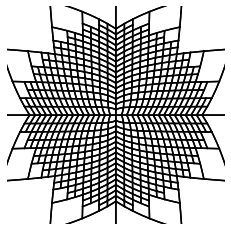

In [34]:
test = mh.containers.HealpixMap(nside=nside)
# Multilevel map, from static map
mtest = test.moc_from_pixels(nside=nside, pixels=uhealpix.ravel() )
mtest.plot_grid(proj='gnom',rot=[0,-90],ysize=1200, xsize=1200)

In [33]:
import pandas as pd

In [34]:
basins = pd.read_csv('./Ant_Grounded_DrainageSystem_Polygons.txt')

In [35]:
b2 = basins[basins.basin == 2]

In [36]:
basins.head

<bound method NDFrame.head of                Lat        Lon  basin
0       -74.525273 -61.122545      1
1       -74.525435 -61.123664      1
2       -74.525467 -61.123826      1
3       -74.525576 -61.124567      1
4       -74.525609 -61.124498      1
...            ...        ...    ...
1238996 -74.523392 -61.109736     27
1238997 -74.523938 -61.113444     27
1238998 -74.524484 -61.117151     27
1238999 -74.525030 -61.120859     27
1239000 -74.525273 -61.122545     27

[1239001 rows x 3 columns]>

60


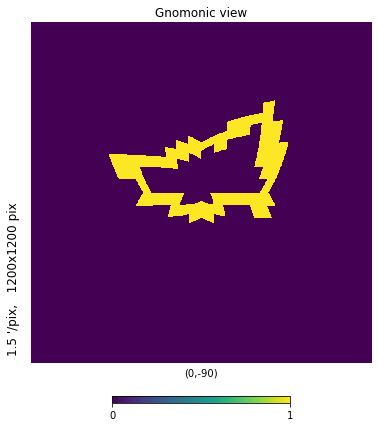

In [50]:
nside = 2**6
b2idx = mh.hp.ang2pix(nside,b2.Lon.values, b2.Lat.values, lonlat=True) 
m = np.zeros(mh.hp.nside2npix(nside))
m[np.unique(b2idx).ravel()] += 1
# Centered on the south pole
mh.hp.gnomview(m, rot=[0,-90], xsize=1200, ysize=1200)# , nest=True)
print(len(np.unique(b2idx).ravel()))

119


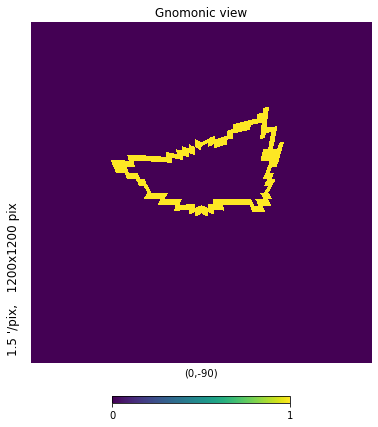

In [51]:
nside = 2**7
b2idx = mh.hp.ang2pix(nside,b2.Lon.values, b2.Lat.values, lonlat=True) 
m = np.zeros(mh.hp.nside2npix(nside))
m[np.unique(b2idx).ravel()] += 1
# Centered on the south pole
mh.hp.gnomview(m, rot=[0,-90], xsize=1200, ysize=1200)# , nest=True)
print(len(np.unique(b2idx).ravel()))

perhaps the best way to compare is to just write out both chunk sizes to aws and check the timings? Well, to do that we'll need to setup the hierarchical naming scheme...

In [30]:
from numpy import r_

In [31]:
def unique2parent(unique):
    '''
    Assumes input is UNIQ
    Currently only works on single resolution
    Returns parent base cell
    '''
    nside = mh.uniq2nside(unique)
    if nside.all():
        order = int(np.log2(nside.max()))
    unique = unique // 4**(order-1)
    parent = (unique - 16) // 4
    #print(order)
    return parent

def bin_rep(A,n):
    """
    like np.binary_repr, except it works on arrays
    not sure why numpy's doesn't
    """
    if n in (8,16,32,64):
        return (np.unpackbits(A.astype(f'>u{n>>3}').view(np.uint8))+ord('0')).view(f'S{n}')
    nb = max((n-1).bit_length()-3,0)
    return (np.unpackbits(A.astype(f'>u{1<<nb}')[...,None].view(np.uint8),axis=1)[...,-n:]+ord('0')).ravel().view(f'S{n}')

def slicer(start=None, stop=None, step=1):
    """
    let's you column slice on fixed width array of strings
    """
    return np.vectorize(lambda x: x[start:stop:step], otypes=[str])

def caster(base=2):
    """
    cast from string 0/1 binary rep to int
    """
    return np.vectorize(lambda x: int(x, base))

def heal_norm(base, order, addr_nest):
    N_pix = mh.hp.order2nside(order)**2
    addr_norm = addr_nest - (base * N_pix)
    return addr_norm


# Old function-- slow and memory inefficient =/
def norm2morton(order, norms, parents=None):
    """
    Uses previous three functions and output from first function to
    give morton number
    Morton number currently doesn't encode base pixel id... 
    although it could...
    
    expects flat arrays
    """
    res = np.zeros((len(norms),order), dtype=np.int64)
    final = np.zeros_like(norms)
    norms = bin_rep(norms, order*2)
    lidx = r_[0:order*2:2]
    for i, bit in enumerate(lidx):
        col = slicer(bit,bit+2)(norms)
        res[:,i] = caster()(col)
    res = res + 1
    res = res.astype(str)
    for i, line in enumerate(res):
        final[i] = ''.join(line)
    if parents is not None:
        parents = parents- 6
        parents = parents * 10**(order)
        final = final + parents
    final = np.array(final, dtype=np.int64)
    return final #, res, norms, lidx
    #ridx = np.flip(r_[order:0:-2])

In [45]:
# Level 6 indexing
len(healidx), len(np.unique(healidx))

(865273104, 113307)

In [46]:
healidx

array([12467702, 12467702, 12467849, ..., 12467653, 12467653, 12467653])

In [44]:
# level 7 indexing
len(healidx_7), len(np.unique(healidx_7))

(865273104, 1946)

The functions I wrote above aren't particularly fast... we'll test on the b2 array to confirm that's true.

In [ ]:
np.int64?

In [ ]:
len(b2.Lon.values) 

notes on gaia conventions for healpix...

This means that the HEALpix index level 12 of a given source is contained in the most significant bits. HEALpix index of 12 and lower levels can thus be retrieved as follows:

- HEALpix level 12 = source_id / 34359738368
- HEALpix level 11 = source_id / 137438953472
- HEALpix level 10 = source_id / 549755813888
- HEALpix level n = source_id / 2 ^ 35 * 4 ^ (12 – level).

In [ ]:
df.healpix_plot(healpix_expression="nest/8388608")

In [ ]:
counts = df.healpix_count(healpix_expression="nest/8388608",healpix_level=18)

In [66]:
np.sum(counts)

865273104

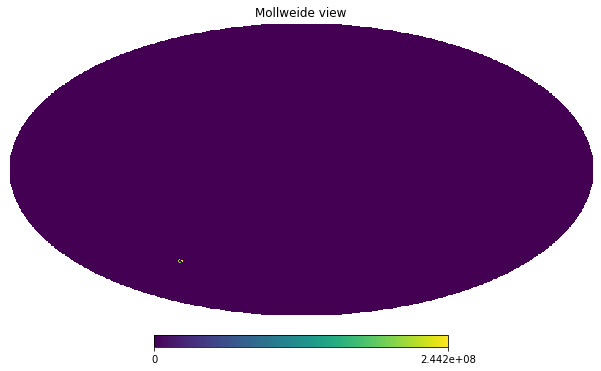

In [68]:
mh.hp.mollview(counts, nest=True, rot=[-90,-90])

In [62]:
df['nest'] = nestcoords

In [59]:
for i in range(6, 20):
    print((i, (2**35) * 4**(12-i)))

(6, 140737488355328)
(7, 35184372088832)
(8, 8796093022208)
(9, 2199023255552)
(10, 549755813888)
(11, 137438953472)
(12, 34359738368)
(13, 8589934592.0)
(14, 2147483648.0)
(15, 536870912.0)
(16, 134217728.0)
(17, 33554432.0)
(18, 8388608.0)
(19, 2097152.0)


In [53]:
nside, 2**12

(128, 4096)

In [54]:
np.log2(34359738368)

35.0

In [55]:
2**35

34359738368

In [ ]:
len(df)

In [99]:
865273104 / 43096df['midx11'] = df.midx // 10**7

20077.805457583072

In [100]:
.286* 20078

5742.307999999999

In [101]:
5742.30 / 3600 # 1.6 hours =/

1.5950833333333334

In [49]:
#%%timeit
# uniq requires nest order
order = 11
uniq = mh.nest2uniq(2**order,mh.hp.ang2pix(2**order,b2.Lon.values, b2.Lat.values, lonlat=True, nest=True))
parents = unique2parent(uniq)
normed = heal_norm(parents,order, uniq)
# norm2morton is slow...
# faster way is to just call it on the unique members of normed, and then cast that
mortons = fastNorm2Mort(order,normed.ravel(), parents.ravel())

In [107]:
#%%timeit
# uniq requires nest order
order = 17
uniq = mh.nest2uniq(2**order,mh.hp.ang2pix(2**order,b2.Lon.values, b2.Lat.values, lonlat=True, nest=True))
parents = unique2parent(uniq)
normed = heal_norm(parents,order, uniq)
# norm2morton is slow...
# faster way is to just call it on the unique members of normed, and then cast that
mortons = norm2morton(order,normed.ravel(), parents.ravel())

In [61]:
normed

array([275014396849, 275014397420, 275014399595, ..., 274946120253,
       274946144102, 274946152540], dtype=int64)

In [109]:
normed[0]

68753599212

In [87]:
2**18

262144

In [126]:
int('1100000000000000000000000000000000000',2)

103079215104

In [110]:
int('110000000000000000000000000000000000',2)

51539607552

In [101]:
int('110000000000000000000000000000000000000000000000000000000000000000000000',2)

3541774862152233910272

In [90]:
np.array(mortons, dtype=np.int64)[0]

4111131131333343412

In [89]:
for i in range(18,0,-1):
    print(normed[0]&2**i)

0
131072
0
32768
0
8192
0
2048
0
512
256
128
0
32
16
0
0
0


In [88]:
normed[0]&262144

0

In [70]:
16 >> ((2*18) - 2)

0

In [71]:
18 - 18 +1

1

In [72]:
18 >> 2

4

In [125]:
np.binary_repr(np.int64(51539607552))

'110000000000000000000000000000000000'

In [149]:
np.binary_repr(np.int64(3*4**(17)))

'110000000000000000000000000000000000'

In [123]:
np.binary_repr(np.int64(normed[0]))

'1000000000010000010001010101011101100'

In [117]:
type(np.int32(normed[0]))

numpy.int32

In [271]:
@vectorize([int64(int64, int64)])#, target='cuda')
def VaexNorm2Mort(normed, parents):
    order = 18
    mask = np.int64(3*4**(order-1))
    res = np.zeros(order,dtype=np.int64)
    num = 0
    for j, i in enumerate(range(order, 0, -1)):
        nextBit = (normed & mask) >> ((2*i) - 2)
        num += (nextBit+1) * 10**(i-1)
        mask = mask >> 2
    parents = parents- 6
    parents = parents * 10**(order)
    num = num + parents
    return num

In [ ]:
#%%timeit
#VaexNorm2Mort(normed, parents)

In [38]:
@vectorize([int64(int64, int64, int64)])#, target='cuda')
def fastNorm2Mort(order, normed, parents):
    if order > 18:
        print("Max order is 18 (to output to 64-bit int)")
        raise ValueError
    mask = np.int64(3*4**(order-1))
    res = np.zeros(order,dtype=np.int64)
    num = 0
    for j, i in enumerate(range(order, 0, -1)):
        nextBit = (normed & mask) >> ((2*i) - 2)
        #res[j] = nextBit
        num += (nextBit+1) * 10**(i-1)
        mask = mask >> 2
#    final = res + 1
#    final = np.int64(''.join(final.astype(str)))
    if parents is not None:
        parents = parents- 6
        parents = parents * 10**(order)
        num = num + parents
    return num

In [265]:
fastNorm2Mort(18, normed[:10], parents[:10])

array([4111113113133334341, 4111113113133342434, 4111113113133423233,
       4111113113134143321, 4111113113134231234, 4111113113134224121,
       4111113113141343132, 4111113113141432111, 4111113113141422224,
       4111113113142141431])

In [233]:
norm2morton(18, normed[0:2]) # ,

array([111113113133334341, 111113113133342434], dtype=int64)

In [225]:
np.binary_repr(fastNorm2Mort(18, normed[:10])[0])

'110001010110000001100100110100110001100110011111101000101'

In [254]:
type(np.array([4111113113133334341], dtype=int)[-1])

numpy.int64

In [201]:
#vmort = np.vectorize(fastNorm2Mort)

In [180]:
%%timeit
vmort(18, normed, parents)

1.9 s ± 123 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [267]:
%%timeit
norm2morton(18, normed) # ,

1.25 s ± 5.47 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [266]:
%%timeit
fastNorm2Mort(18, normed , parents)

7.15 ms ± 57.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [234]:
%%timeit
fastNorm2Mort(18, normed) # , parents)

6.99 ms ± 102 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [181]:
%%timeit
mortons = norm2morton(18,normed.ravel(), parents.ravel())

1.4 s ± 19.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [210]:
from numba import jit, vectorize, int64

In [174]:
parents

array([10, 10, 10, ...,  9,  9,  9])

In [177]:
fastNorm2Mort(17, normed[:5],parents[:5])

ValueError: setting an array element with a sequence.

In [167]:
normed[0]

68753599212

In [134]:
mask = 51539607552//4
#mask = 3541774862152233910272
hpidx = np.int32(normed[0])
order = 17
res = np.zeros(17,dtype=int)
for j, i in enumerate(range(17,0,-1)):
    nextBit = (hpidx & mask) >> ((2*i) - 2)
    #print(18-i +1)
    #print(nextBit)
    res[j] = nextBit
    #print(mask)
    mask = mask >> 2

res+1

array([1, 1, 1, 1, 3, 1, 1, 3, 1, 3, 3, 3, 3, 4, 3, 4, 1])

In [151]:
final = res +1

In [155]:
''.join(final.astype(str))

'11113113133334341'

In [111]:
np.array(mortons, dtype=np.int64)[0]

411113113133334341

In [105]:
mask = 51539607552
#mask = 3541774862152233910272
hpidx = normed[0]
for i in range(18,0,-1):
    nextBit = (hpidx & mask) >> ((2*i) - 2)
    #print(18-i +1)
    print(nextBit)
    #print(mask)
    mask = mask >> 2


0
0
0
0
2
0
0
2
0
2
2
2
2
3
2
3
0
1


In [106]:
np.array(mortons, dtype=np.int64)[0]

4111131131333343412

In [58]:
9_223_372_036_854_775_807

9223372036854775807

In [59]:
511_143_211_121_311

511143211121311

In [60]:
np.int64(mortons.astype(str)[0])

4111131131333343412

In [48]:
mortons.astype(str)[0]

'4111131131333343412'

In [ ]:
mortons[0]

In [ ]:
# order 18 is the max that'll fit in int space.... i.e, 25 meter bins

In [111]:
mortons[0]

111131

In [115]:
parents - 6

array([4, 4, 4, ..., 3, 3, 3])

In [178]:
%%timeit
df.track.str.contains('gt3').sum()

5.19 s ± 40.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [187]:
%%timeit
df.track.str.match('gt3r').sum()

5.45 s ± 35.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [198]:
%%timeit
df.track.str.startswith('gt3').sum()

1.01 s ± 7.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
so we'll use the mhealpy library where possible, and then map the unique id's back to indexing scheme

In [201]:
2030* 1354*12*24

791602560

In [35]:
%%compile?

Object `%%compile` not found.


In [36]:
from ctypes import *

#load the shared object file
adder = CDLL('./adder.so')


In [40]:
#Find sum of integers
res_int = adder.add_int(4,5)
print(("Sum of 4 and 5 = " + str(res_int)))

#Find sum of floats
a = c_float(5.5)
b = c_float(4.1)

add_float = adder.add_float
add_float.restype = c_float
print(("Sum of 5.5 and 4.1 = ", str(add_float(a, b))))

Sum of 4 and 5 = 9
('Sum of 5.5 and 4.1 = ', '9.600000381469727')


In [41]:
res_int

9

In [43]:
adder.add_int(np.array(9,9,9), np.array(1,2,3))

TypeError: array() takes from 1 to 2 positional arguments but 3 were given